In [263]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels

import tensorflow

import keras
from keras.models import Model
from keras.layers import Input, Flatten, Conv2D, MaxPool2D, Dense, BatchNormalization, Dropout, AlphaDropout
from keras.optimizers import Adam, RMSprop, Nadam
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard as TensorBoardCallback
from keras.utils import to_categorical

# Fashion Classification

<img src="https://raw.githubusercontent.com/roma-glushko/zelando-fashion-mnist/master/doc/fashion-mnist.png" width="600px" />

In [10]:
RANDOM_SEED = 20210116

np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)

In [11]:
train_df = pd.read_csv('data/fashion-mnist_train.csv')
test_df = pd.read_csv('data/fashion-mnist_test.csv')

# Dataset Overview

In [12]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
X_train, y_train = train_df.drop(['label'], axis=1), train_df['label']
X_test, y_test = test_df.drop(['label'], axis=1), test_df['label']

<AxesSubplot:xlabel='label', ylabel='Count'>

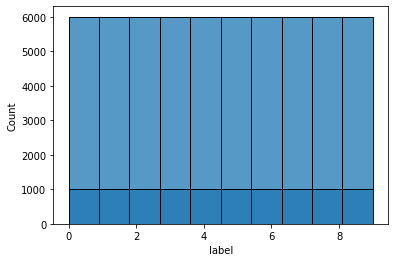

In [14]:
sns.histplot(data=y_train, bins=10)
sns.histplot(data=y_test, bins=10)

In [15]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [16]:
val_splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_SEED)

for train_idx, val_idx in val_splitter.split(X_train, y_train):
    X_train_val, y_train_val = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

In [129]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.001, random_state=RANDOM_SEED)

for _, val_idx in splitter.split(X_train, y_train):
    X_train_overfit, y_train_overfit = X_train.iloc[val_idx], y_train.iloc[val_idx]

In [17]:
label_names = [
    'T-shirt/Top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot',
]

label_num = len(label_names)

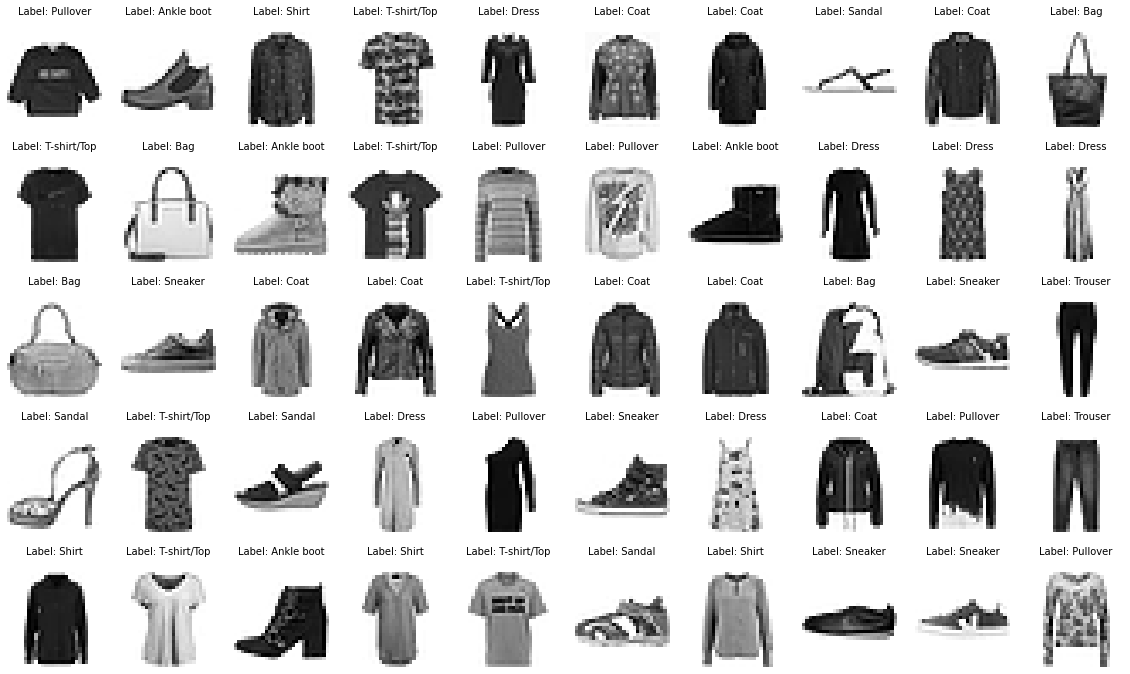

In [18]:
plt.figure(figsize=(20, 12))

for index, (image, label_idx) in enumerate(zip(X_train[0:50], y_train[0:50])):
    label = label_names[label_idx]

    ax = plt.subplot(5, 10, index + 1)
    ax.axis('off')

    plt.imshow(np.reshape(X_train.values[index], (28, 28)), cmap='binary')

    plt.title('Label: %s\n' % label, fontsize=10);

# Classification

In [19]:
def plot_confusion_matrix_by_predictions(y_true, y_predicted, *, labels=None,
                          sample_weight=None, normalize=None,
                          display_labels=None, include_values=True,
                          xticks_rotation='horizontal',
                          values_format=None, colorbar=False,
                          cmap='rocket_r', ax=None):
    
    cm = confusion_matrix(y_true, y_predicted, sample_weight=sample_weight,
                          labels=labels, normalize=normalize)

    if display_labels is None:
        if labels is None:
            display_labels = unique_labels(y_true, y_predicted)
        else:
            display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    return disp.plot(include_values=include_values,
                     cmap=cmap, ax=ax, xticks_rotation=xticks_rotation,
                     values_format=values_format, colorbar=colorbar)


In [171]:
def plot_misclassified_samples(true_label, pred_label):
    missclass_label_indices = [
        idx for idx, (label_true, label_pred) in enumerate(zip(y_test, y_test_pred)) 
        if label_true == true_label and label_pred == pred_label
    ]

    fig = plt.figure(figsize=(20, 10))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    for i, idx in enumerate(missclass_label_indices[:30]):    
        ax = fig.add_subplot(3, 10, i + 1)
        ax.axis('off')

        ax.text(0.5, -0.35, 'ID = ' + str(idx), fontsize=10, ha='center', transform=ax.transAxes) 
        ax.text(0.5, -0.6, 'pred = ' + label_names[y_test_pred[idx]], fontsize=10, ha='center', transform=ax.transAxes) 
        ax.text(0.5, -0.8, 'act = ' + label_names[y_test[idx]], fontsize=10, ha='center', transform=ax.transAxes)
        ax.imshow(np.reshape(X_test.values[idx], (28, 28)), cmap='binary')

In [227]:
def plot_learning_history(training_history):
    training_history_df = pd.DataFrame(training_history.history)

    training_history_df[['loss', 'val_loss']].plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)

    training_history_df[['accuracy', 'val_accuracy']].plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)

    print(("Best Val Loss: {:0.4f}" +\
        "\nBest Val Accuracy: {:0.4f}")\
        .format(training_history_df['val_loss'].min(), 
                training_history_df['val_accuracy'].max()))

In [20]:
def get_log_dir():
    training_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
    return os.path.join(os.curdir, 'logs', training_id)

## FMLP

In [181]:
mlp_input_layer = Input((784), name='input')

#x = Dense(300, activation='relu')(input_layer)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

#x = Dense(100, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

#x = Dense(50, activation='relu')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

mlp = Dense(300, activation='selu', kernel_initializer='lecun_normal', name='dense_1')(mlp_input_layer)
mlp = AlphaDropout(0.2, name='alpha_dropout_1')(mlp)

mlp = Dense(100, activation='selu', kernel_initializer='lecun_normal', name='dense_2')(mlp)
mlp = AlphaDropout(0.2, name='alpha_dropout_2')(mlp)

mlp = Dense(50, activation='selu', kernel_initializer='lecun_normal', name='dense_3')(mlp)
mlp = AlphaDropout(0.2, name='alpha_dropout_3')(mlp)

mlp_output_layer = Dense(label_num, activation='softmax', name='dense_output')(mlp)

mlp_model = Model(mlp_input_layer, mlp_output_layer, name='SR_FMLP')

mlp_model.summary()

Model: "SR_FMLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 784)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               235500    
_________________________________________________________________
alpha_dropout_1 (AlphaDropou (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               30100     
_________________________________________________________________
alpha_dropout_2 (AlphaDropou (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
alpha_dropout_3 (AlphaDropou (None, 50)                0   

In [182]:
optimizer = Nadam(lr=0.001)

mlp_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

In [183]:
early_stopping_callback = EarlyStopping(patience=15, restore_best_weights=True)
checkpoint_callback = ModelCheckpoint('checkpoints/fashion-mlp-classifier.h5', save_best_only=True)
tensorboard_callback = TensorBoardCallback(get_log_dir(), histogram_freq=1, write_graph=True, write_images=True)

training_history = mlp_model.fit(
    X_train_val, y_train_val, 
    #X_train_overfit, y_train_overfit,
    validation_data=(X_val, y_val),
    epochs=200,
    batch_size=256,
    callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback]
)

Epoch 1/200
188/188 [==============================] - 3s 9ms/step - loss: 1.3041 - accuracy: 0.5343 - val_loss: 0.6223 - val_accuracy: 0.8138
Epoch 2/200
188/188 [==============================] - 1s 8ms/step - loss: 0.5851 - accuracy: 0.7883 - val_loss: 0.5393 - val_accuracy: 0.8307
Epoch 3/200
188/188 [==============================] - 1s 6ms/step - loss: 0.4927 - accuracy: 0.8240 - val_loss: 0.4881 - val_accuracy: 0.8479
Epoch 4/200
188/188 [==============================] - 1s 6ms/step - loss: 0.4624 - accuracy: 0.8335 - val_loss: 0.5373 - val_accuracy: 0.8385
Epoch 5/200
188/188 [==============================] - 1s 6ms/step - loss: 0.4362 - accuracy: 0.8409 - val_loss: 0.4691 - val_accuracy: 0.8590
Epoch 6/200
188/188 [==============================] - 1s 6ms/step - loss: 0.4195 - accuracy: 0.8499 - val_loss: 0.4592 - val_accuracy: 0.8614
Epoch 7/200
188/188 [==============================] - 1s 7ms/step - loss: 0.3966 - accuracy: 0.8549 - val_loss: 0.4850 - val_accuracy: 0.8533

### Evaluation

Best Val Loss: 0.3695
Best Val Accuracy: 0.9033


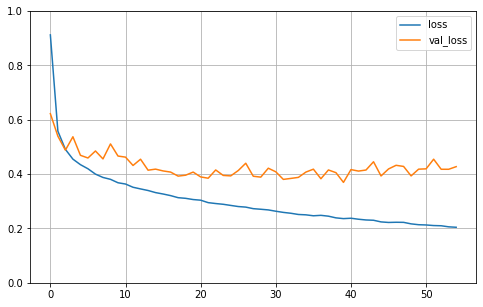

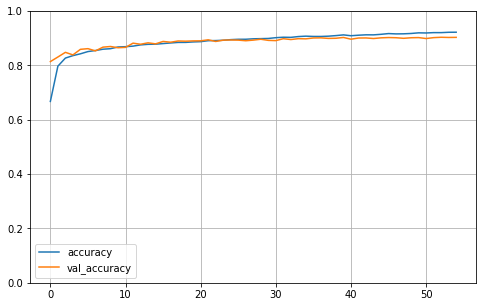

In [184]:
plot_learning_history(training_history)

In [185]:
mlp_model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 758us/step - loss: 0.4167 - accuracy: 0.8968


[0.41666552424430847, 0.8967999815940857]

In [186]:
y_test_pred = np.argmax(mlp_model.predict(X_test), axis=-1)

Test Report
              precision    recall  f1-score   support

           0     0.8080    0.8840    0.8443      1000
           1     0.9772    0.9870    0.9821      1000
           2     0.8610    0.7990    0.8288      1000
           3     0.9147    0.9120    0.9134      1000
           4     0.8209    0.8660    0.8428      1000
           5     0.9732    0.9450    0.9589      1000
           6     0.7530    0.6860    0.7179      1000
           7     0.9203    0.9590    0.9393      1000
           8     0.9761    0.9810    0.9786      1000
           9     0.9615    0.9490    0.9552      1000

    accuracy                         0.8968     10000
   macro avg     0.8966    0.8968    0.8961     10000
weighted avg     0.8966    0.8968    0.8961     10000



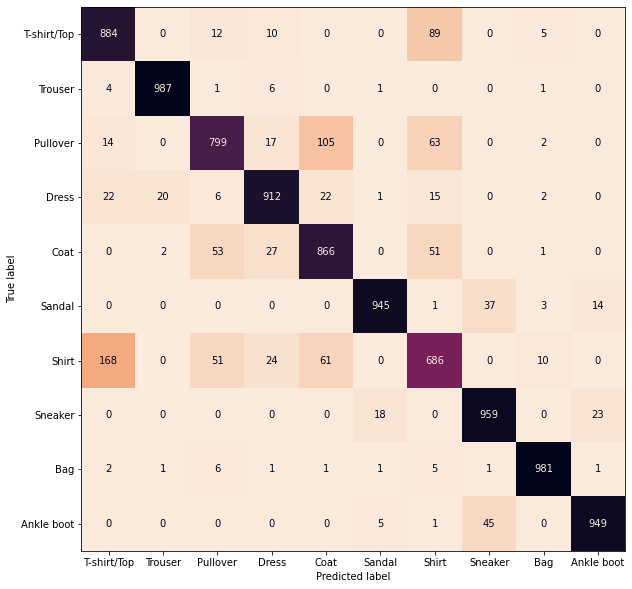

In [187]:
print('Test Report')
print(classification_report(y_test, y_test_pred, digits=4))

matrix = plot_confusion_matrix_by_predictions(y_test, y_test_pred, display_labels=label_names)
matrix.figure_.set_figheight(10)
matrix.figure_.set_figwidth(10)

In [ ]:
## Chance Model
# Loss: 2.43648624420166
# Accuracy: 0.12780000269412994

## Dense(300, activation='relu'), Dense(100, activation='relu'), SGD
# Best Val Loss: 0.3154
# Best Val Accuracy: 0.8987
# Best Test Loss: 0.3189171850681305
# Best Test Accuracy: 0.8956999778747559

## Dense(300, activation='relu'), Dense(100, activation='relu'), Adam(lr=0.0005)
# Best Val Loss: 0.3054
# Best Val Accuracy: 0.8972
# Best Test Loss: 0.31720462441444397
# Best Test Accuracy: 0.8913999795913696

## Dense(300, activation='relu'), BatchNorm(), Dense(100, activation='relu'), BatchNorm(), Adam(lr=0.0005)
# Best Val Loss: 0.3020
# Best Val Accuracy: 0.8958
# Best Test Loss: 0.33810487389564514
# Best Test Accuracy: 0.8925999999046326

## Adam(lr=0.0005), Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.2882
# Best Val Accuracy: 0.8964
# Best Test Loss: 0.3012319505214691
# Best Test Accuracy: 0.8920000195503235

## Adam(lr=0.0005), batch_size=32, Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2), Dense(50, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.2822
# Best Val Accuracy: 0.9010
# Best Test Loss: 0.29744410514831543
# Best Test Accuracy: 0.8920999765396118

## Adam(lr=0.0005), batch_size=64, Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2), Dense(50, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.3215
# Best Val Accuracy: 0.9032
# Best Test Loss: 0.29807841777801514
# Best Test Accuracy: 0.8945000171661377

## RMSprop(), batch_size=32, Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2), Dense(50, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.3024
# Best Val Accuracy: 0.8970
# Best Test Loss: 0.3157300651073456
# Best Test Accuracy: 0.8924000263214111

## RMSprop(), batch_size=256, Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2), Dense(50, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.2886
# Best Val Accuracy: 0.9017
# Best Test Loss: 0.2969489097595215
# Best Test Accuracy: 0.8981000185012817

## Adam(lr=0.0005), batch_size=256, Dense(300, activation='relu'), BatchNorm(), Dropout(0.2), Dense(100, activation='relu'), BatchNorm(), Dropout(0.2), Dense(50, activation='relu'), BatchNorm(), Dropout(0.2)
# Best Val Loss: 0.2938
# Best Val Accuracy: 0.9023
# Best Test Loss: 0.29765433073043823
# Best Test Accuracy: 0.8996000289916992

## Nadam(lr=0.0005), batch_size=256, Dense(300, activation='selu'), AlphaDropout(0.2), Dense(100, activation='selu'), AlphaDropout(0.2), Dense(50, activation='selu'), AlphaDropout(0.2)
# Best Val Loss: 0.3629
# Best Val Accuracy: 0.9026
# Best Test Loss: 0.39967575669288635
# Best Test Accuracy: 0.8942999839782715

## Nadam(lr=0.001), batch_size=256, Dense(300, activation='selu', kernel_initializer='lecun_normal'), AlphaDropout(0.2), Dense(100, activation='selu', kernel_initializer='lecun_normal'), AlphaDropout(0.2), Dense(50, activation='selu', kernel_initializer='lecun_normal'), AlphaDropout(0.2)
# Best Val Loss: 0.4443
# Best Val Accuracy: 0.9081
# Best Test Loss: 0.5121541023254395
# Best Test Accuracy: 0.8996999859809875

### Error Analysis

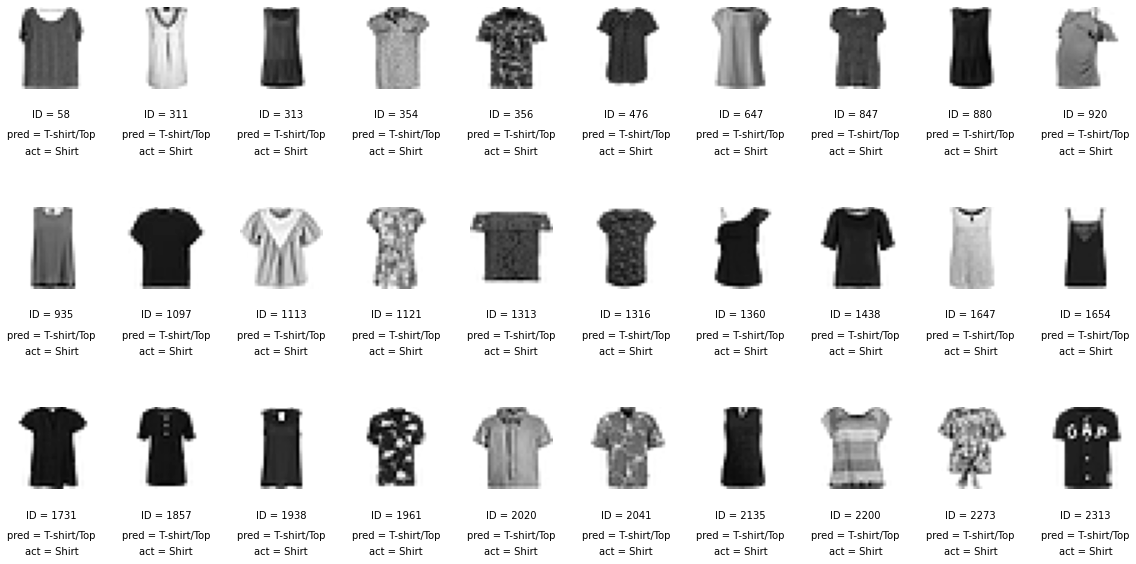

In [172]:
plot_misclassified_samples(true_label=6, pred_label=0)

## CNN

In [485]:
X_train2d = X_train.to_numpy().reshape((-1, 28, 28))
y_train_onehot = to_categorical(y_train, label_num)

X_test2d = X_test.to_numpy().reshape((-1, 28, 28))
y_test_onehot = to_categorical(y_test, label_num)

X_train_val2d = X_train_val.to_numpy().reshape((-1, 28, 28))
y_train_val_onehot = to_categorical(y_train_val, label_num)

X_val2d = X_val.to_numpy().reshape((-1, 28, 28))
y_val_onehot = to_categorical(y_val, label_num)

In [486]:
cnn_input_layer = Input((28, 28, 1), name='input')

cnn = Conv2D(64, 7, activation='relu', padding='same', name='conv1_low_level')(cnn_input_layer)
cnn = MaxPool2D(2, name='pooling1')(cnn)

cnn = Conv2D(128, 3, activation='relu', padding='same', name='conv2_1_double')(cnn)
cnn = Conv2D(128, 3, activation='relu', padding='same', name='conv2_2_double')(cnn)
cnn = MaxPool2D(2, name='pooling2')(cnn)

cnn = Conv2D(256, 3, activation='relu', padding='same', name='conv3_1_double')(cnn)
cnn = Conv2D(256, 3, activation='relu', padding='same', name='conv3_2_double')(cnn)
cnn = MaxPool2D(2, name='pooling3')(cnn)

cnn = Flatten()(cnn)

cnn = Dense(128, activation='relu', name='dense1')(cnn)
cnn = Dropout(0.2, name='dropout1')(cnn)

cnn = Dense(64, activation='relu', name='dense2')(cnn)
cnn = Dropout(0.2, name='dropout2')(cnn)

cnn_output_layer = Dense(label_num, activation='softmax', name='dense_output')(cnn)

cnn_model = Model(cnn_input_layer, cnn_output_layer, name='CNN')

cnn_model.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv1_low_level (Conv2D)     (None, 28, 28, 64)        3200      
_________________________________________________________________
pooling1 (MaxPooling2D)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2_1_double (Conv2D)      (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2_2_double (Conv2D)      (None, 14, 14, 128)       147584    
_________________________________________________________________
pooling2 (MaxPooling2D)      (None, 7, 7, 128)         0         
_________________________________________________________________
conv3_1_double (Conv2D)      (None, 7, 7, 256)         295168  

In [487]:
optimizer = Nadam(lr=0.001)

cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)

In [484]:
early_stopping_callback = EarlyStopping(patience=15, restore_best_weights=True)

checkpoint_callback = ModelCheckpoint('checkpoints/fashion-cnn-classifier.h5', save_best_only=True)
tensorboard_callback = TensorBoardCallback(get_log_dir(), histogram_freq=1, write_graph=True, write_images=True)

cnn_training_history = cnn_model.fit(
    X_train_val2d, y_train_val_onehot, 
    validation_data=(X_val2d, y_val_onehot),
    epochs=200,
    batch_size=256,
    callbacks=[tensorboard_callback, checkpoint_callback, early_stopping_callback]
)

Epoch 1/200
  7/188 [>.............................] - ETA: 1:40 - loss: 2.2823 - accuracy: 0.1323

KeyboardInterrupt: 

### Evaluation

Best Val Loss: 0.2382
Best Val Accuracy: 0.9224


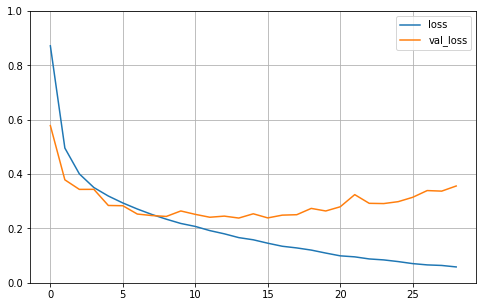

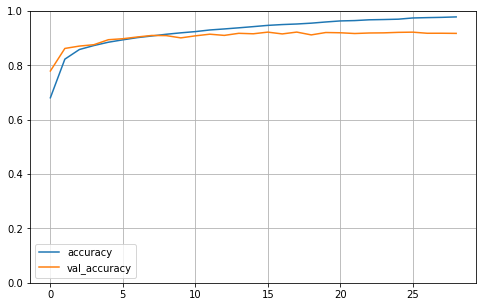

In [248]:
plot_learning_history(cnn_training_history)

In [251]:
cnn_model.evaluate(X_test2d, y_test_onehot)

313/313 [==============================] - 2s 6ms/step - loss: 0.2433 - accuracy: 0.9136


[0.24330417811870575, 0.9136000275611877]

Test Report
              precision    recall  f1-score   support

           0     0.8627    0.8610    0.8619      1000
           1     0.9950    0.9860    0.9905      1000
           2     0.8942    0.8280    0.8598      1000
           3     0.9216    0.9290    0.9253      1000
           4     0.8486    0.8910    0.8693      1000
           5     0.9938    0.9610    0.9771      1000
           6     0.7458    0.7600    0.7528      1000
           7     0.9454    0.9700    0.9576      1000
           8     0.9743    0.9840    0.9791      1000
           9     0.9612    0.9660    0.9636      1000

    accuracy                         0.9136     10000
   macro avg     0.9143    0.9136    0.9137     10000
weighted avg     0.9143    0.9136    0.9137     10000



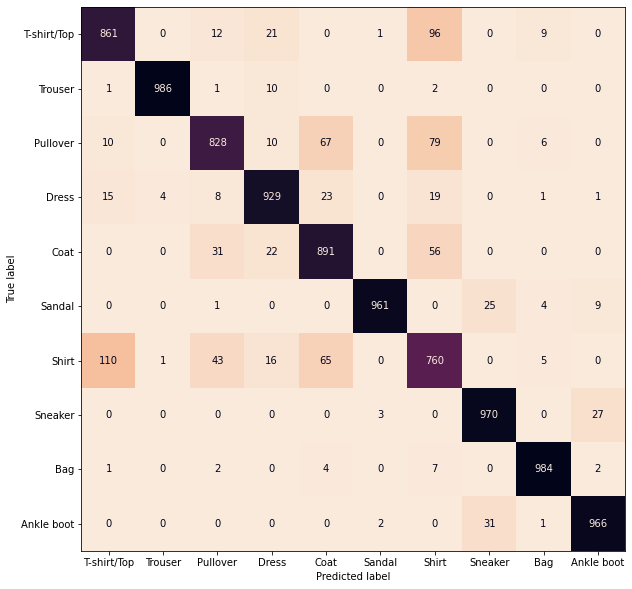

In [253]:
y_test_pred = np.argmax(cnn_model.predict(X_test2d), axis=-1)

print('Test Report')
print(classification_report(y_test, y_test_pred, digits=4))

matrix = plot_confusion_matrix_by_predictions(y_test, y_test_pred, display_labels=label_names)
matrix.figure_.set_figheight(10)
matrix.figure_.set_figwidth(10)

In [481]:
def plot_conv_output(model, layer_name, test_input):
    model_layers = dict([(layer.name, layer) for layer in model.layers])

    inspection_model = Model(inputs=model.inputs, outputs=model_layers[layer_name].output)

    sample_feature_maps = inspection_model.predict(test_input)

    for feature_maps in sample_feature_maps:
        fig = plt.figure(figsize=(25, 25))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        feature_maps = tensorflow.transpose(feature_maps, [2, 1, 0])

        for i, feature_map in enumerate(feature_maps):
            ax = fig.add_subplot(20, 10, i + 1)
            ax.axis('off')

            ax.imshow(feature_map, cmap='binary')

    return fig

In [482]:
plot_conv_output(cnn_model, 'conv1_low_level', np.array([X_test2d[0]]))

KeyError: 'Conv1_LowLevelFeatures'

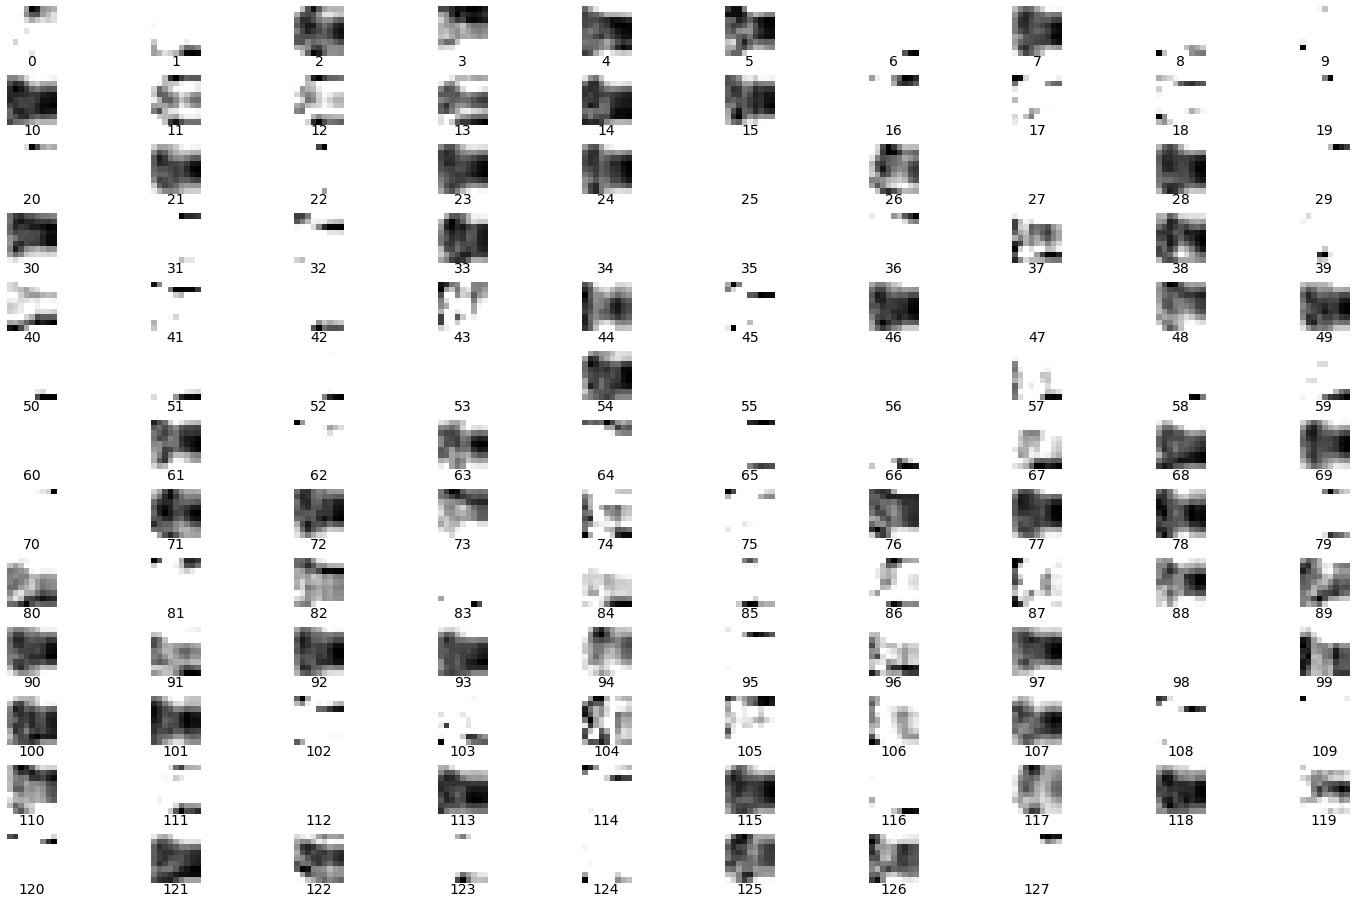

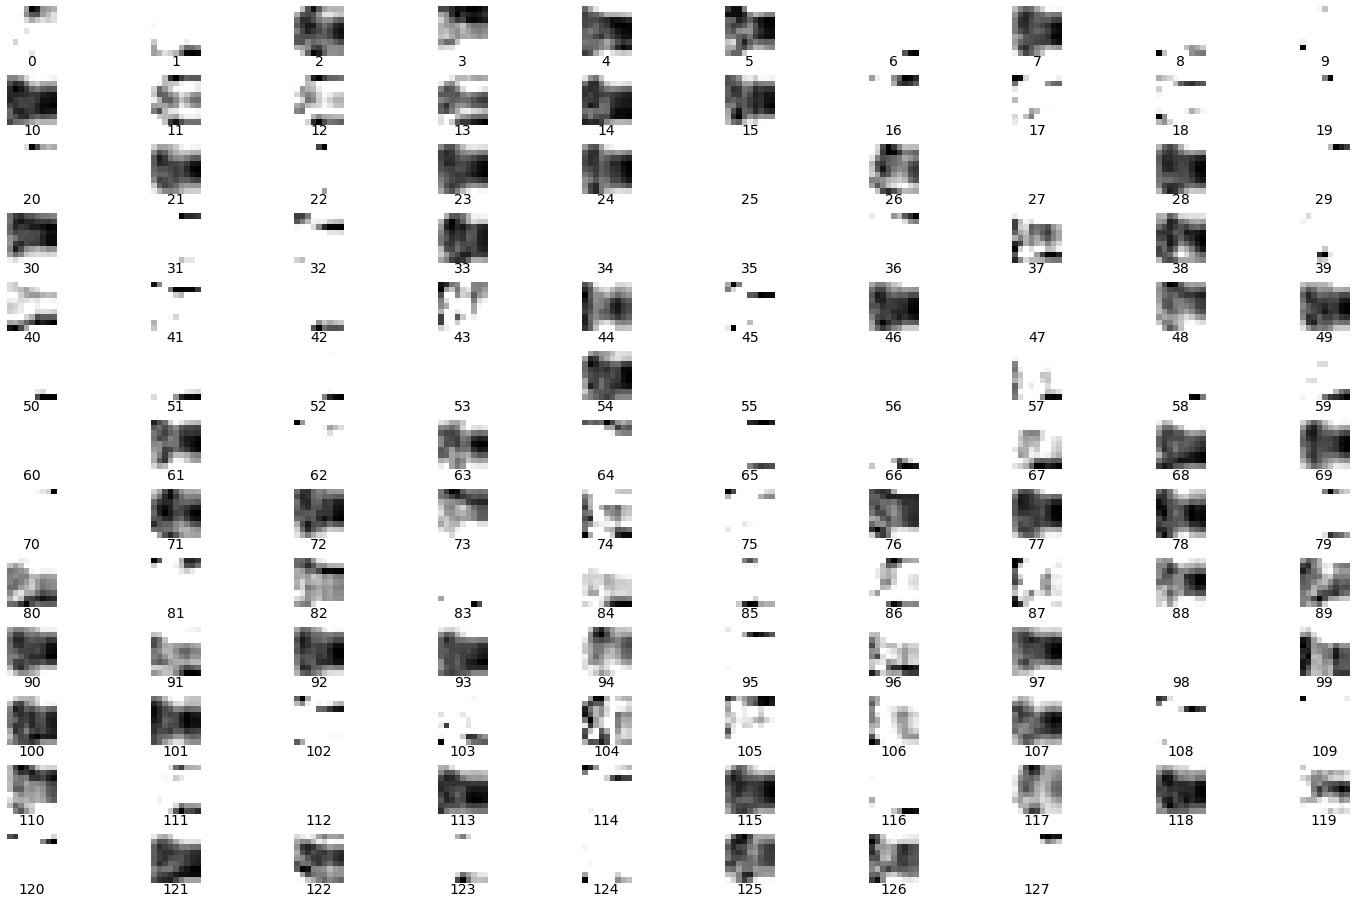

In [474]:
plot_conv_output(cnn_model, 'conv2_1_double', np.array([X_test2d[0]]))

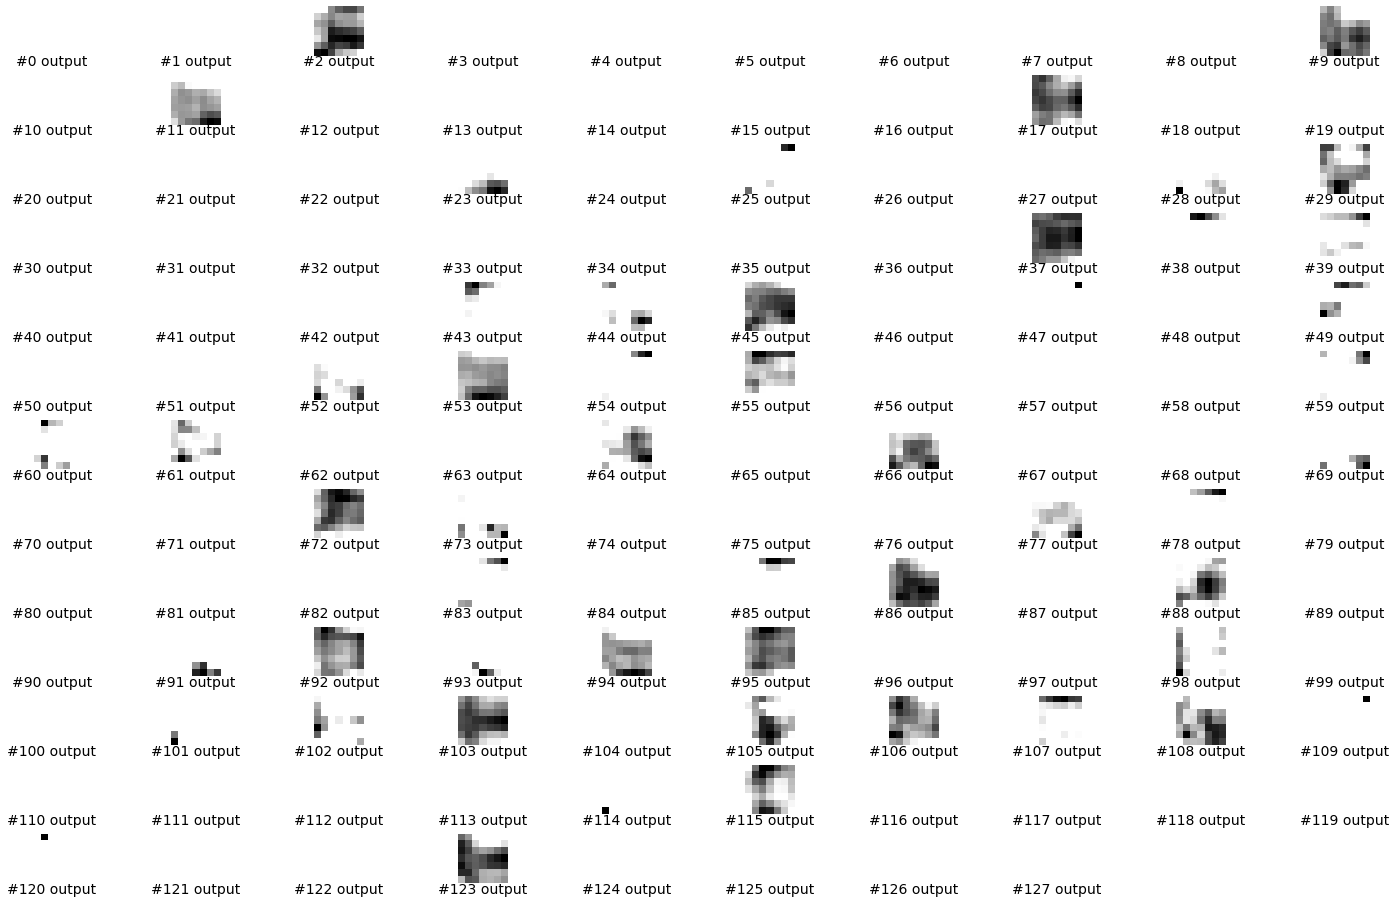

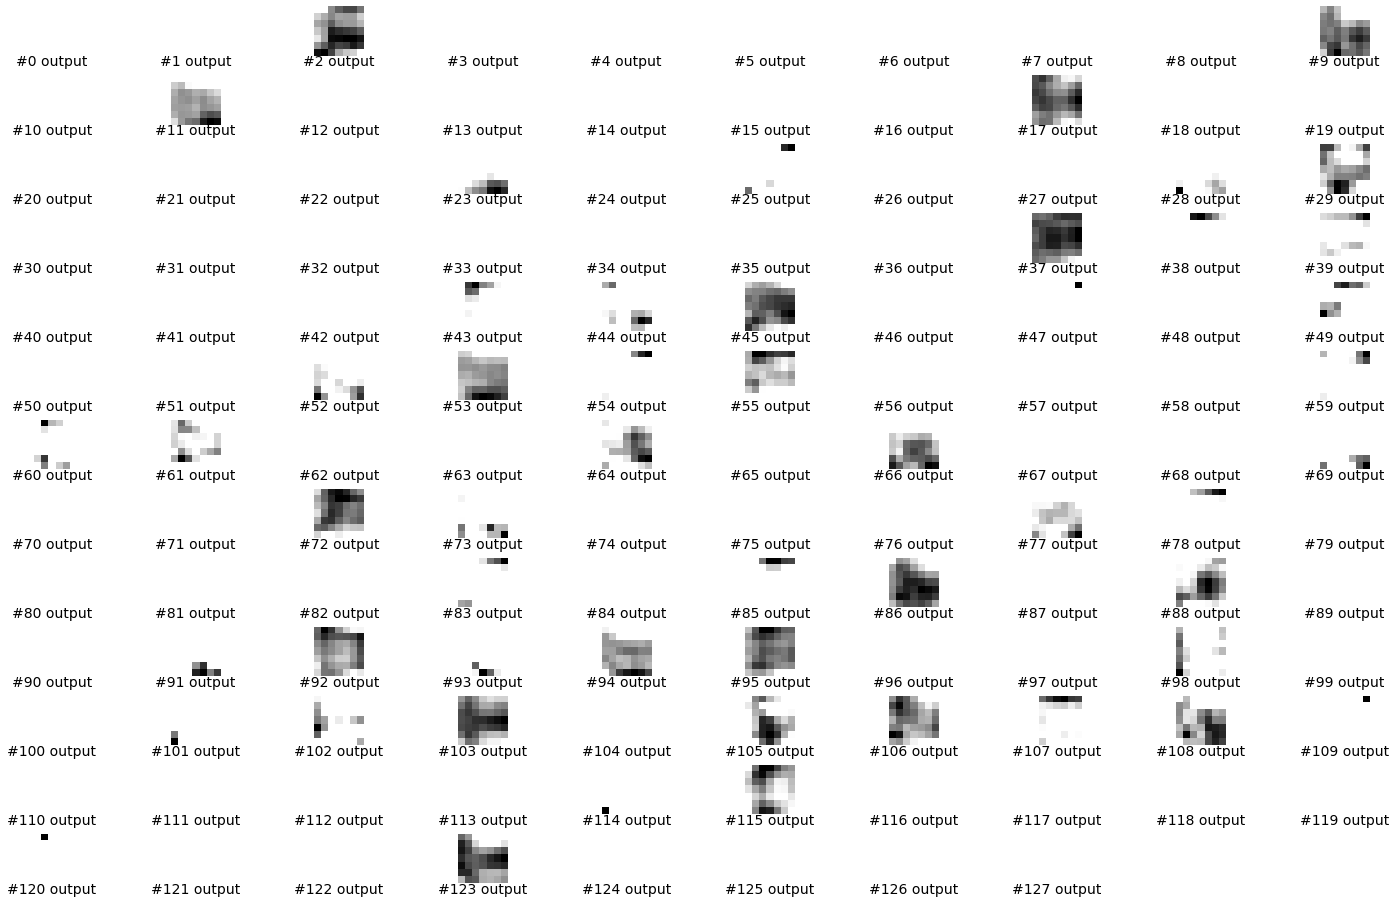

In [471]:
plot_conv_output(cnn_model, 'conv2_2_double', np.array([X_test2d[0]]))

### Experiment Notes

#### Baseline CNN
- Val Loss: 0.2382
- Test Loss: 0.2433 
- Val Accuracy: 0.9224
- Test Accuracy: 0.9136

```
cnn = Conv2D(64, 7, activation='relu', name='conv1_low_level')(cnn_input_layer)
cnn = MaxPool2D(2)(cnn)

cnn = Conv2D(128, 3, activation='relu', name='conv2_1_double')(cnn)
cnn = Conv2D(128, 3, activation='relu', name='conv2_2_double')(cnn)

cnn = Flatten()(cnn)

cnn = Dense(128, activation='relu', name='dense1')(cnn)
cnn = Dropout(0.2, name='dropout1')(cnn)
cnn = Dense(64, activation='relu', name='dense2')(cnn)
cnn = Dropout(0.2, name='dropout2')(cnn)

batch_size=256
```